Extended Kalman Filter

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def wrapToPi(x):
    """
    Wraps the input angle to the range [-pi, pi].
    """
    return (x + np.pi) % (2 * np.pi) - np.pi

class extended_kalman_filter:
    def __init__(self, model, init):
        self.A = model.A  # State transition Jacobian
        self.B = model.B # Input matrix Jacobian
        self.f = model.f  # process model
        self.H = model.H  # measurement model Jacobian
        self.Q = model.Q  # input noise covariance
        self.R = model.R  # measurement noise covariance
        self.h = model.h  # measurement model
        self.x = init.x  # state vector
        self.Sigma = init.Sigma  # state covariance
    
    def prediction(self):
        self.x_pred = self.f(self.x)
        self.Sigma_pred = self.A @ self.Sigma @ self.A.T + self.Q
        self.z_hat = self.h(self.x_pred)

    def correction(self, z):
        # Evaluate measurement Jacobian at current state prediction
        H = self.H(self.x_pred)

        # Compute Kalman gain
        self.v = z - self.z_hat
        self.v[1] = wrapToPi(self.v[1])  # Wrap angle to [-pi, pi]
        self.S = H @ self.Sigma_pred @ H.T + self.R
        self.K = self.Sigma_pred @ H.T @ np.linalg.inv(self.S)

        # Update state and covariance
        self.x = self.x_pred + self.K @ self.v
        I = np.eye(self.x.shape[0])
        self.Sigma = (I - self.K @ H) @ self.Sigma_pred @ (I - self.K @ H).T + self.K @ self.R @ self.K.T


C:\Users\hyunseokshin\AppData\Local\Temp\ipykernel_29044\2402834096.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [math.atan2(x[0], x[1])]])


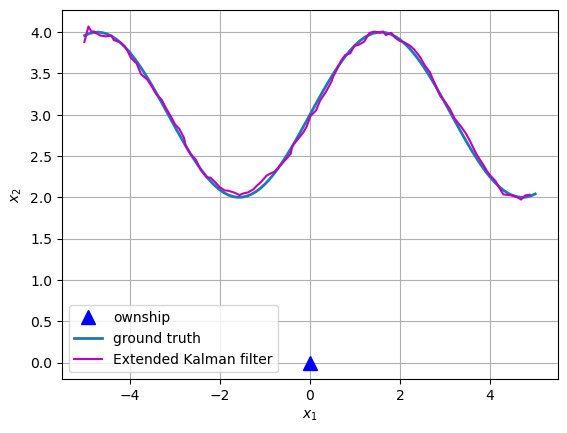

In [47]:
class myStruct:
    pass

# process model
def process_model(x):
    f = np.array([[x[0]],[x[1]]])
    return f.reshape([2, 1])

# measurement model
def measurement_model(x):
    h = np.array([[np.sqrt(np.sum(x[0]**2 + x[1]**2))],
                  [math.atan2(x[0], x[1])]])
    return h.reshape([2, 1])

def measurement_jacobian(x):
    H = np.array([[x[0]/np.sqrt(x[0]**2 + x[1]**2), x[1]/np.sqrt(x[0]**2 + x[1]**2)],
                  [x[1]/(x[0]**2 + x[1]**2), -x[0]/(x[0]**2 + x[1]**2)]])
    return H.reshape([2, 2])

# ground truth model
gt = myStruct()
gt.x = np.arange(-5, 5.1, 0.1)
gt.y = np.array(1 * np.sin(gt.x) + 3)

# measurement model
R = np.diag([0.05**2, 0.01**2])
# Cholesky factor of covariance for sampling
L = np.linalg.cholesky(R)
z = np.zeros([2, len(gt.x)])
for i in range(len(gt.x)):
    noise = L @ (np.random.randn(2,1)).reshape(-1)
    z[:,i] = np.array([np.sqrt(gt.x[i]**2 + gt.y[i]**2),
                       math.atan2(gt.x[i], gt.y[i])]) + noise

# build system model
model = myStruct()
model.A = np.eye(2)
model.B = np.zeros([2, 2])
model.f = process_model
model.h = measurement_model
model.H = measurement_jacobian
model.Q = np.diag([0.001, 0.001])  # Process noise covariance
model.R = R

# Initial state and covariance
init = myStruct()
init.x = np.zeros([2, 1])
init.x[0, 0] = z[0, 0] * np.sin(z[1, 0])
init.x[1, 0] = z[0, 0] * np.cos(z[1, 0])
init.Sigma = 1 * np.eye(2)

ekf = extended_kalman_filter(model, init)
x = []
x.append(init.x)  # state
# main loop; iterate over the measurement
for i in range(1, np.shape(z)[1], 1):
    ekf.prediction()
    ekf.correction(z[:, i].reshape([2, 1]))
    x.append(ekf.x)

x = np.array(x)

# plot
fig = plt.figure()
line1, = plt.plot(0, 0, '^', color='b', markersize=10, label='Ownship')
line2, = plt.plot(gt.x, gt.y, '-', linewidth=2)
line3, = plt.plot(x[:, 0, :], x[:, 1, :], '-m', linewidth=1.5)
# line4, = plt.plot(z[1,:],z[0,:])
plt.legend([line1, line2, line3], [r'ownship', r'ground truth', r'Extended Kalman filter'], loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.grid(True)
plt.show()